In [45]:
import torch
from torch import nn
import numpy as np
import gym 
import matplotlib.pyplot as plt
import tqdm
import time
import glob
import json
import os
from collections import defaultdict

In [2]:

PREF = ''
TASKS_DIR = './tasks' + PREF + '/'
EXP_DIR = './experiments' + PREF + '/'
state_dim = 8
action_n = 4

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
torch.__version__

'1.5.0'

In [22]:
l = 10
ll =len([0,1,2,3])

In [23]:
list(range(ll, l))

[4, 5, 6, 7, 8, 9]

In [56]:
def epsilon_greedy_policy(epsilon, q_value):
    n_actions = q_value.shape[1]
    pol = np.zeros(q_value.shape)+ epsilon/n_actions
    idx = np.argmax(q_value, axis=1)
    pol[np.arange(q_value.shape[0]),idx] += 1-epsilon
    return pol

def epsilon_greedy_policy_action(epsilon, state, q_value, n_actions):
    pol = np.zeros((n_actions,))+ epsilon/n_actions
    idx = np.argmax(q_value[state])
    pol[idx] += 1 - epsilon
    return np.random.choice(n_actions, p=pol)

def get_action(policy, state):
    return np.random.choice(policy.shape[1], p=policy[state])

def gratitude(gamma, rewards):
    G = np.zeros((len(rewards),))
    T = len(rewards)
    for t in range(T-1):
        for epsodes_n in range(t, T-1):
            G[t] += gamma**(epsodes_n-t) * rewards[epsodes_n]
    return G

def get_trajectory(env, policy, trajectory_n):
    rewards = []
    actions = []
    states = []
    state = env.reset()
    for _ in range(trajectory_n):
        states.append(state)
        action = get_action(policy, state)
        actions.append(action)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break
    return states, actions, rewards


In [50]:
Q = defaultdict(lambda : np.zeros((4,)))

In [171]:
env = gym.make('LunarLander-v2')
# n_states = env.observation_space.n
env.action_space


Discrete(4)

In [6]:
state = env.reset()

In [172]:
env.observation_space


Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

In [203]:
def get_lunar_state_nbr(state):
    # The state is an 8-dimensional vector: the coordinates of the lander in x & y,
    # its linear velocities in x & y, its angle, its angular velocity, 
    # and two booleans that represent whether each leg is in contact with the ground or not.
    x,y,vx,vy,a,va,tl,tr = state
    
    new_state =[ x*10,y*10,vx*10,vy*10, a*10,va*10, tl, tl]
    return '_'.join([str(int(s)) for s in new_state])

In [169]:
def get_state_nbr(state):
    return '_'.join([str(int(s*100)) for s in state])

In [198]:
Q[get_state_nbr(state)][1]=1

In [199]:
Q

defaultdict(<function __main__.QLearning.<locals>.<lambda>()>,
            {'-4_1411_-409_27_4_92_0_0': array([-0.15834973,  0.        ,  0.        ,  0.        ]),
             '-8_1411_-408_1_9_91_0_0': array([0.        , 0.        , 0.03766288, 0.        ]),
             '-12_1412_-397_34_14_103_0_0': array([ 0.        , -0.80943021,  0.        ,  0.        ]),
             '-16_1412_-407_7_21_143_0_0': array([-0.35892235,  0.        ,  0.        ,  0.        ]),
             '-20_1412_-407_-18_28_143_0_0': array([-0.41626231,  0.        ,  0.        ,  0.        ]),
             '-24_1411_-407_-45_35_143_0_0': array([ 0.        , -0.95345258,  0.        ,  0.        ]),
             '-28_1409_-415_-72_44_174_0_0': array([ 0.     , -1.21681,  0.     ,  0.     ]),
             '-32_1407_-425_-100_55_215_0_0': array([ 0.        , -1.28694254,  0.        ,  0.        ]),
             '-36_1404_-434_-127_68_251_0_0': array([ 0.       ,  0.       ,  0.       , -0.2257434]),
             

In [16]:
env.action_space

Discrete(4)

In [204]:
def MC(epsodes_n, trajectory_len, epsilon, gamma):
    env = gym.make('LunarLander-v2')
    n_actions = 4
    N = defaultdict(lambda : np.zeros((n_actions,)))
    Q = defaultdict(lambda : np.zeros((n_actions,)))
    G = None
    total_rewards = []
    for ki in tqdm.tqdm(range(epsodes_n)):
        
        rewards = []
        state = get_lunar_state_nbr(env.reset())
        actions = []
        states = []

        for _ in range(trajectory_len):
            action = epsilon_greedy_policy_action(epsilon, state, Q, n_actions)
            state, reward, done, _ = env.step(action)
            state = get_lunar_state_nbr(state)
            rewards.append(reward)
            states.append(state)
            actions.append(action)
            if done:
                break
            # updating Q
        # policy = epsilon_greedy_policy(epsilon, Q)
        #states, actions, rewards = get_trajectory(env, policy, trajectory_n)
        total_rewards.append(int(np.sum(rewards, dtype=np.int32)))
        G = gratitude(gamma, rewards)
        
        # updating Q
        for g, a, s in zip(G, actions, states):
            Q[s][a] += (g - Q[s][a])/(N[s][a]+1)
            N[s][a] += 1

        epsilon=1-ki/epsodes_n
#         epsilon*=0.8
    return total_rewards

In [211]:
tr, q, n, G = MC(20000,300, 1, 0.99)

100%|██████████| 20000/20000 [11:20<00:00, 29.39it/s]


In [212]:
G

array([-128.19876631, -130.08365942, -131.87148696, -133.53009623,
       -136.18694527, -138.81463731, -141.63431761, -144.35219009,
       -146.98894848, -148.12730314, -148.46746828, -148.47446038,
       -147.92366755, -148.32685281, -147.71508082, -147.12061858,
       -146.00231808, -143.55604183, -146.11474073, -143.7637701 ,
       -141.7939168 , -145.34456073, -145.15103064, -147.81167201,
       -145.96235201, -149.29567718, -147.61723207, -146.19137836,
       -145.41566061, -144.12307781, -143.29535323, -146.08903466,
       -144.88474452, -149.71468955, -148.44503042, -147.13131231,
       -145.49343138, -143.64367554, -141.82582556, -140.19493283,
       -138.59319422, -137.02293548, -135.20860284, -133.06619053,
       -130.74252397, -128.18405673, -125.48464488, -123.02044315,
       -120.58829335, -118.1887681 , -115.82232279, -112.81248442,
       -109.59694224, -106.80577343, -104.04448263, -101.3133944 ,
        -98.61279952,  -97.36984334,  -94.13954457,  -91.39225

In [213]:
len(q.keys())

340440

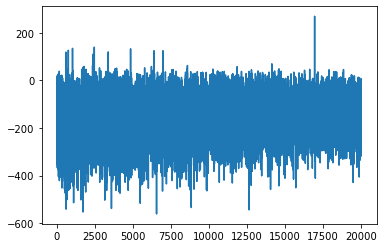

In [214]:
plt.plot(range(len(tr)), tr)

In [70]:
def SARSA(epsodes_n, trajectory_len, alpha, epsilon, gamma):
    env = gym.make('LunarLander-v2')
    n_actions = 4
    Q = defaultdict(lambda : np.zeros((n_actions,)))

    # stats = []
    # policies = []
    total_rewards = []

    for ki in tqdm.tqdm(range(epsodes_n)):
        rewards = []
        state = get_state_nbr(env.reset())
        action = epsilon_greedy_policy_action(epsilon, state, Q, n_actions)
        
        actions = [action]
        states = [state]

        for _ in range(trajectory_len):

            state, reward, done, _ = env.step(action)
            state = get_state_nbr(state)
            rewards.append(reward)
            states.append(state)
            action = epsilon_greedy_policy_action(epsilon, state, Q, n_actions)
            actions.append(action)
            if done:
                break
            # updating Q
            Q[states[-2]][actions[-2]] += alpha*(reward + gamma*Q[states[-2]][actions[-2]])-Q[states[-2]][actions[-2]]

        total_rewards.append(int(np.sum(rewards, dtype=np.int32)))
        epsilon=1/(ki+1)
    return total_rewards, Q


In [77]:
tr, Q = SARSA(10000, 600, 0.1, 1, 0.9)

100%|██████████| 10000/10000 [02:15<00:00, 74.07it/s]


In [78]:
len(Q.keys())

695856

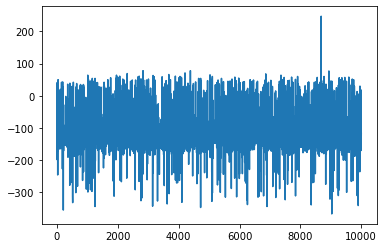

In [79]:
plt.plot(range(len(tr)), tr)

In [76]:
Q

defaultdict(<function __main__.SARSA.<locals>.<lambda>()>,
            {'0_140_-77_-29_0_17_0_0': array([ 0.        , -0.22574545,  0.        ,  0.        ]),
             '-1_139_-78_-32_1_21_0_0': array([ 0.        , -0.27615154,  0.        ,  0.        ]),
             '-2_138_-79_-34_3_26_0_0': array([-0.16057046,  0.        ,  0.        ,  0.        ]),
             '-3_138_-79_-37_4_26_0_0': array([ 0.        , -0.27832693,  0.        ,  0.        ]),
             '-3_137_-80_-40_6_30_0_0': array([ 0.        , -0.29457297,  0.        ,  0.        ]),
             '-4_136_-81_-42_7_34_0_0': array([ 0.        , -0.29522608,  0.        ,  0.        ]),
             '-5_135_-82_-45_9_38_0_0': array([ 0.        ,  0.        ,  0.        , -0.10834999]),
             '-6_134_-81_-48_11_33_0_0': array([0.        , 0.        , 0.07098526, 0.        ]),
             '-7_133_-81_-44_13_35_0_0': array([ 0.        ,  0.        , -0.13983004,  0.        ]),
             '-7_132_-82_-43_15_34_

In [216]:
def QLearning(epsodes_n, trajectory_n, alpha, epsilon, gamma):
    env = gym.make('LunarLander-v2')
    n_actions = 4
    Q = defaultdict(lambda : np.zeros((n_actions,)))

    # stats = []
    # policies = []
    total_rewards = []

    for ki in tqdm.tqdm(range(epsodes_n)):
        rewards = []
        state = env.reset()
        state = get_lunar_state_nbr(state)
        action = epsilon_greedy_policy_action(epsilon, state, Q, n_actions)
        
        actions = [action]
        states = [state]

        for _ in range(trajectory_n):
            state, reward, done, _ = env.step(action)
            state = get_lunar_state_nbr(state)

            rewards.append(reward)
            states.append(state)
            action = epsilon_greedy_policy_action(epsilon, state, Q, n_actions)
            actions.append(action)
            if done:
                break

            # updating Q
            Q[states[-2]][actions[-2]] += alpha*(reward + gamma*max(Q[states[-1]]))-Q[states[-2]][actions[-2]]

        total_rewards.append(int(np.sum(rewards, dtype=np.int32)))
        epsilon=1/(ki+1)
    return total_rewards, Q

In [221]:
tr, Q = QLearning(1000, 100, 0.999, 1, 0.5554)

100%|██████████| 1000/1000 [00:39<00:00, 25.36it/s]


In [222]:
len(Q)

28667

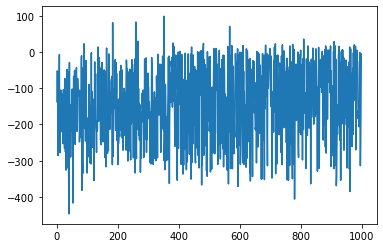

In [223]:
plt.plot(range(len(tr)), tr)

In [24]:
class CrossEntropyMethod(nn.Module):
    def __init__(self, name, state_dim, action_n, layers_n, lr=0.01):
        super().__init__()
        self.name = name
        self.state_dim = state_dim
        self.action_n = action_n
        self.lr = lr
        self.__print = True
        if len(layers_n)==1:
            self.network = nn.Sequential(
                nn.Linear(self.state_dim, layers_n[0]),
                nn.ReLU(),
                nn.Linear(layers_n[0], self.action_n)
            )
        if len(layers_n)==2:
            self.network = nn.Sequential(
                nn.Linear(self.state_dim, layers_n[0]),
                nn.ReLU(),
                nn.Linear(layers_n[0], layers_n[1]),
                nn.ReLU(),
                nn.Linear(layers_n[1], self.action_n)
            )
        if len(layers_n)==3:
            self.network = nn.Sequential(
                nn.Linear(self.state_dim, layers_n[0]),
                nn.ReLU(),
                nn.Linear(layers_n[0], layers_n[1]),
                nn.ReLU(),
                nn.Linear(layers_n[1], layers_n[2]),
                nn.ReLU(),
                nn.Linear(layers_n[2], self.action_n)
            )

        self.softmax = nn.Softmax()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.loss = nn.CrossEntropyLoss()
#         self.to(device)
#         self.policy = np.ones((self.state_n, self.action_n)) / self.action_n
    def silent(self):
        self.__print = False
    def forward(self, _input):
        return self.network(_input)
    
    def get_action(self, state):
        state = torch.FloatTensor(state)# .to(device)
        logits = self.network(state)
        action_prob = self.softmax(logits).detach().numpy()
        action = np.random.choice(self.action_n, p=action_prob)
        return action

    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        assert len(elite_states)==len(elite_actions), f'{len(elite_states)},{len(elite_actions)}'

        elite_states = torch.FloatTensor(elite_states)#.to(device)
        elite_actions = torch.LongTensor(elite_actions)#.to(device)
        loss = self.loss(self.forward(elite_states), elite_actions)
        # calculating gradients
        loss.backward()
        # update the weights
        self.optimizer.step()
        # zero grad
        self.optimizer.zero_grad()
        self.save_policy()
    def get_name(self):
        return os.path.join(EXP_DIR, self.name+'.nn')
    def load_n_policy(self, n):
        files = list(glob.glob(os.path.join(EXP_DIR, self.name,str(n)+'_*.nn')))
        if self.__print : print('policies count', len(files))
#         start_from_start = len(files) == 0
        if len(files) > 0:
            file = files[0]# list(sorted(files, key=lambda x: int(x.split('/')[-1].split('_')[0])))[-1]
            if self.__print : print('loading last policy',file)
            self.load_state_dict(torch.load(file))
            return True
        return False
    def load_last_policy(self):
        files = list(glob.glob(os.path.join(EXP_DIR, self.name,'*.nn')))
        if self.__print : print('policies count', len(files))
        start_from_start = len(files) == 0
        if len(files) > 0:
            file = list(sorted(files, key=lambda x: int(x.split('/')[-1].split('_')[0])))[-1]
            if self.__print : print('loading '+str(n)+' policy',file)
            self.load_state_dict(torch.load(file))
            return True
        return False

In [25]:
def get_trajectory(env, agent, trajectory_len, visualize=False):
    trajectory = {
        'states':[], 
        'actions':[],
        'safe': True,
        'solved': False,
        'total_reward': 0}
    state = env.reset()
#     trajectory['states'].append(state)\
    agent._crashed = False
    for _ in range(trajectory_len):
        action = agent.get_action(state)
        trajectory['states'].append(state)
        trajectory['actions'].append(action)
        state, reward, done, _ = env.step(action)
        if reward == -100:
            trajectory['safe']=False
        if reward == 200:
            trajectory['solved']=True
        trajectory['total_reward'] += reward
        if done:
            break
        
        if visualize:
            env.render()

    assert len(trajectory['actions'])==len(trajectory['states']), f"gt {len(trajectory['actions'])},{len(trajectory['states'])}"
    return trajectory

In [26]:
def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param) 
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]

In [27]:
def get_stats(eid, n, tn):
    ed = json.load(open(os.path.join(EXP_DIR, eid+".json")))
    lr = ed['lr']
    layers_n = ed['layers_n']
    episode_n = ed['episode_n']
    trajectory_len = ed['trajectory_len']
    trajectory_n = ed['trajectory_n']
    q_param = ed['q_param']
    total_elapsed = ed['total_elapsed']
#     print(f'lr={lr}\nlayers_n={layers_n} \nepisode_n={episode_n}\ntrajectory_len={trajectory_len} \ntrajectory_n={trajectory_n} \nq_param={q_param} \ntotal_elapsed={total_elapsed}')
    
    # env = gym.make('CartPole-v1')
    env = gym.make('LunarLander-v2')
    agent = CrossEntropyMethod(eid, state_dim, action_n, layers_n=layers_n)
    agent.silent()
    if not agent.load_n_policy(n):
        print('Faild to load policy :-( ')
        return []
    trajectories = [get_trajectory(env, agent, trajectory_len) for _ in range(tn)]
    
    rewards = [trajectory['total_reward'] for trajectory in trajectories]
    safety = [trajectory['safe'] for trajectory in trajectories]
    solved = [trajectory['solved'] for trajectory in trajectories]
    mean_total_reward = np.mean(rewards)
    return rewards, np.sum(safety)/tn, np.sum(solved)/tn
#     plt.hist(rewards, bin=50)
    

In [28]:
def success(r):
    r = np.array(r)
    p = np.sum(r > 0)/len(r)
    return p, 1-p

In [29]:
rewards = get_stats('2290748504803', 139, 60)

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [12]:
def replay_stats(eid, tn):
    ed = json.load(open(os.path.join(EXP_DIR, eid+".json")))
    lr = ed['lr']
    layers_n = ed['layers_n']
    episode_n = ed['episode_n']
    trajectory_len = ed['trajectory_len']
    trajectory_n = ed['trajectory_n']
    q_param = ed['q_param']
    total_elapsed = ed['total_elapsed']
    global_stats = []
    print(f'lr={lr}\nlayers_n={layers_n} \nepisode_n={episode_n}\ntrajectory_len={trajectory_len} \ntrajectory_n={trajectory_n} \nq_param={q_param} \ntotal_elapsed={total_elapsed}')
    
    for e in tqdm.tqdm_notebook(range(episode_n)):
        rewards, safety, solved = get_stats(eid, e, tn)
        if len(rewards) ==0:
            global_stats.append([0,0])
            continue
        global_stats.append([np.mean(rewards), safety, solved])
    return global_stats

In [437]:
global_stats = replay_stats('2290748504803', 30)

lr=0.01
layers_n=[200] 
episode_n=200
trajectory_len=500 
trajectory_n=300 
q_param=0.7 
total_elapsed=11197.60418


/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/h

In [438]:
global_stats = np.array(global_stats)

global_stats

array([[-1.71122639e+02,  0.00000000e+00,  0.00000000e+00],
       [-1.17748621e+02,  0.00000000e+00,  0.00000000e+00],
       [-1.32619597e+02,  0.00000000e+00,  0.00000000e+00],
       [-1.12166545e+02,  0.00000000e+00,  0.00000000e+00],
       [-1.04562236e+02,  0.00000000e+00,  0.00000000e+00],
       [-1.27826422e+02,  0.00000000e+00,  0.00000000e+00],
       [-1.07954515e+02,  0.00000000e+00,  0.00000000e+00],
       [-8.48334424e+01,  6.66666667e-02,  0.00000000e+00],
       [-9.06179200e+01,  0.00000000e+00,  0.00000000e+00],
       [-3.62055563e+01,  1.00000000e-01,  0.00000000e+00],
       [-4.96710363e+01,  3.33333333e-02,  0.00000000e+00],
       [-5.99838468e+01,  2.00000000e-01,  0.00000000e+00],
       [-4.33375909e+01,  6.66666667e-02,  0.00000000e+00],
       [-3.33538402e+01,  2.00000000e-01,  0.00000000e+00],
       [ 1.09125726e+01,  3.00000000e-01,  0.00000000e+00],
       [ 1.71371581e+01,  2.66666667e-01,  0.00000000e+00],
       [ 2.22018374e+01,  3.00000000e-01

In [439]:
json.load(open(os.path.join(EXP_DIR, '2290748504803'+".json")))

{'id': '2290748504803',
 'version': '1',
 'layers_n': [200],
 'episode_n': 200,
 'trajectory_len': 500,
 'trajectory_n': 300,
 'q_param': 0.7,
 'total_elapsed': 11197.60418,
 'finished': True,
 'episode_data': [[-199.06034121559202, 90],
  [-187.51886426500997, 90],
  [-163.4782110244763, 90],
  [-137.03541213396878, 90],
  [-119.06788151759841, 90],
  [-111.81401161396352, 90],
  [-87.0626547609202, 90],
  [-92.77526666693406, 90],
  [-82.78611728292765, 90],
  [-79.96721653289926, 90],
  [-67.00925093329141, 90],
  [-59.545009687158576, 90],
  [-54.63369343867797, 90],
  [-30.162159548665084, 90],
  [-19.99866700032623, 90],
  [-2.1757656027039225, 90],
  [5.18886430824409, 90],
  [9.066487479308643, 90],
  [19.658012599050863, 90],
  [17.351089820038506, 90],
  [31.237684366803094, 90],
  [21.366706620868943, 90],
  [22.563516555427555, 90],
  [43.18255175006114, 90],
  [41.06071676405802, 90],
  [40.44348941401503, 90],
  [55.79060079938929, 90],
  [56.14942481266711, 90],
  [59.35

In [440]:
ed = ed['episode_data']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
ed = np.array(ed)

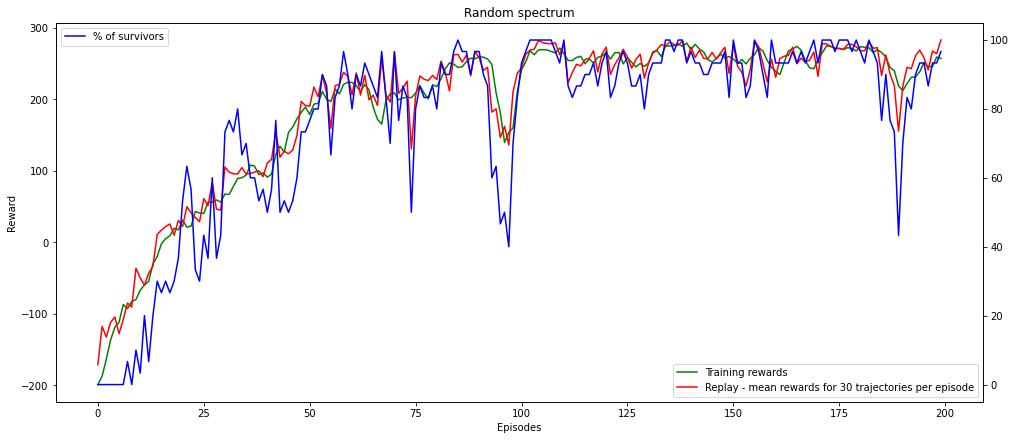

In [443]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(14,6))
l1=ax.plot(range(len(ed)), ed[::,0], color='green', label='Training rewards')
l2=ax.plot(range(len(global_stats)), global_stats[::,0], color='red',label='Replay - mean rewards for 30 trajectories per episode')
ax.set_xlabel('Episodes')
ax.set_ylabel('Reward')
ax.set_title('Random spectrum')
leg = plt.legend(loc='lower right')
# the function "1/x" is its own inverse
ax2 = ax.twinx()
ax2.plot(range(len(global_stats)), global_stats[::,1]*100, color='blue', label='% of survivors')
leg = plt.legend(loc='upper left')

plt.show()

In [445]:
import pandas as pd

In [459]:
sdf = pd.DataFrame(global_stats[global_stats[::,1]==1], columns=['Reward', 'Survivers','-'])

In [463]:
sdf[['Reward', 'Survivers']]

,Reward,Survivers
0,262.951434,1.0
1,269.111621,1.0
2,270.265116,1.0
3,282.396529,1.0
4,279.517435,1.0
5,278.370167,1.0
6,277.963013,1.0
7,277.992915,1.0
8,274.999818,1.0
9,280.340668,1.0


In [ ]:
2290748504803 mean:189.3  Neyron:[200] 139
2292098547091 mean:166.8  Neyron:[200] 197
2292024736000 mean:159.1  Neyron:[150] 178
6418223916 mean:134.1  Neyron:[200] 146
2291950921733 mean:133.4  Neyron:[100] 189

In [31]:
# env = gym.make('CartPole-v1')
env = gym.make('LunarLander-v2')

In [32]:
img = env.render(mode='rgb_array')

plt.imshow(img)

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


ResetNeeded: Cannot call `env.render()` before calling `env.reset()`, if this is a intended action, set `disable_render_order_enforcing=True` on the OrderEnforcer wrapper.

In [ ]:
en

In [33]:
state = env.reset()

In [35]:
x,y, dx, dy, a, da, tl, tr = state

# he coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

In [36]:
x,y, dx, dy, a, da, tl, tr

(0.003987789,
 1.4019362,
 0.40390483,
 -0.3992897,
 -0.0046140645,
 -0.091490336,
 0.0,
 0.0)

In [37]:
env.render()

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/gym/core.py:50: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  "You are calling render method, "


In [246]:
actions = [ agent.get_action(state) for i in range(10)]
actions

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[3, 3, 1, 1, 2, 2, 1, 2, 0, 2]

In [247]:
logits = [agent.network(torch.FloatTensor(state)) for i in range(10)]
logits 

[tensor([ 0.0351,  0.1288,  0.0145, -0.0349], grad_fn=<AddBackward0>),
 tensor([ 0.0351,  0.1288,  0.0145, -0.0349], grad_fn=<AddBackward0>),
 tensor([ 0.0351,  0.1288,  0.0145, -0.0349], grad_fn=<AddBackward0>),
 tensor([ 0.0351,  0.1288,  0.0145, -0.0349], grad_fn=<AddBackward0>),
 tensor([ 0.0351,  0.1288,  0.0145, -0.0349], grad_fn=<AddBackward0>),
 tensor([ 0.0351,  0.1288,  0.0145, -0.0349], grad_fn=<AddBackward0>),
 tensor([ 0.0351,  0.1288,  0.0145, -0.0349], grad_fn=<AddBackward0>),
 tensor([ 0.0351,  0.1288,  0.0145, -0.0349], grad_fn=<AddBackward0>),
 tensor([ 0.0351,  0.1288,  0.0145, -0.0349], grad_fn=<AddBackward0>),
 tensor([ 0.0351,  0.1288,  0.0145, -0.0349], grad_fn=<AddBackward0>)]

In [249]:
# action_prob = self.softmax(logits).cpu().detach().numpy()
action_prob = agent.softmax(logits[0]).detach().numpy()


/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [257]:
action = np.random.choice(agent.action_n, p=action_prob)
action

1

In [237]:
action

1

In [58]:
mean_total_rewards = []

In [205]:
from queue import Queue
import threading


In [211]:
import datetime

In [215]:
datetime.datetime.now(), 

(datetime.datetime(2022, 11, 22, 20, 1, 43, 336861),
 datetime.datetime(2022, 11, 22, 20, 1, 33, 336864))

In [203]:
q=Queue()

In [204]:
q.put(get_trajectory(env, agent, 10))

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
os.makedirs()

In [209]:
q.get()

KeyboardInterrupt: 

In [210]:
import time
import threading
from queue import Queue
import numpy as np

In [ ]:
def get_trajectory_mt(task_queue, output_queue, env, agent, trajectory_len):
    while True:
        if task_queue.empty(): break
        _ = task_queue.get()
        
        trajectory = get_trajectory(env, agent, trajectory_len, visualize=False)
        output_queue.put(trajectory)
        
        task_queue.task_done()

def get_trajectories_mt(env, agent, trajectory_n,t rajectory_len, threads):
    
    task_queue = Queue()
    output_queue = Queue()
    for i in range(trajectory_n)
        task_queue.put(i)

    for index in range(num_worker_threads):
        thread = threading.Thread(target=get_trajectory_mt, args=(task_queue, output_queue, env, agent, trajectory_len))
        thread.start()
        thread.join()

        outputQ.put()
            outputQ
    ret = [q.get() for q in output_queue]

In [59]:
for _ in tqdm.tqdm_notebook(range(episode_n)):
    trajectories = [get_trajectory(env, agent, trajectory_len) for _ in range(trajectory_n)]
    
    mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
    mean_total_rewards.append(mean_total_reward)
    print(mean_total_reward)
    
    elite_trajectories = get_elite_trajectories(trajectories, q_param)
    
    if len(elite_trajectories)>0:
        agent.update_policy(elite_trajectories)

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


-174.3044616594158
-200.51771481427826
-214.60137719501896
-156.8390113802936
-167.21130480895204
-134.51633116260095
-152.56419807918547
-122.66981892874912
-145.27520837277848



KeyboardInterrupt: 

In [39]:
torch.save(agent.state_dict(), 'test')

In [101]:
def replay(eid, episodes = 100):
    ed = json.load(open(os.path.join(EXP_DIR, eid+".json")))

    layers_n = ed['layers_n']
    episode_n = ed['episode_n']
    trajectory_len = ed['trajectory_len']
    trajectory_n = ed['trajectory_n']
    q_param = ed['q_param']
    total_elapsed = ed['total_elapsed']
    print(f'layers_n={layers_n} \nepisode_n={episode_n}\ntrajectory_len={trajectory_len} \ntrajectory_n={trajectory_n} \nq_param={q_param} \ntotal_elapsed={total_elapsed}')
    agent = CrossEntropyMethod(eid, state_dim, action_n, layers_n=layers_n)
    agent.load_policy()
    tjs = []
    while True:
        t = get_trajectory(env, agent, trajectory_len, visualize=True)
        tjs.append(t['total_reward'])

In [103]:
def get_stats(eid, episodes):
    ed = json.load(open(os.path.join(EXP_DIR, eid+".json")))

    layers_n = ed['layers_n']
    episode_n = ed['episode_n']
    trajectory_len = ed['trajectory_len']
    trajectory_n = ed['trajectory_n']
    q_param = ed['q_param']
    total_elapsed = ed['total_elapsed']
    print(f'layers_n={layers_n} \nepisode_n={episode_n}\ntrajectory_len={trajectory_len} \ntrajectory_n={trajectory_n} \nq_param={q_param} \ntotal_elapsed={total_elapsed}')
    agent = CrossEntropyMethod(eid, state_dim, action_n, layers_n=layers_n)
    agent.load_policy()
    tjs = []
    for _ in tqdm.tqdm(range(episodes)):
        t = get_trajectory(env, agent, trajectory_len, visualize=False)
        tjs.append(t['total_reward'])
    return tjs

In [102]:
replay(eid = '6405310643')

layer_n1=100 
episode_n=200
trajectory_len=1000 
trajectory_n=70 
q_param=0.8 
total_elapsed=6484.341369


/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/gym/core.py:50: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  "You are calling render method, "


KeyboardInterrupt: 

In [105]:
get_stats('6405310643', 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

layer_n1=100 
episode_n=200
trajectory_len=1000 
trajectory_n=70 
q_param=0.8 
total_elapsed=6484.341369


/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]


[290.92685005787155,
 235.7335628801832,
 269.09268472190445,
 232.52486479591977,
 296.37371441847745,
 275.2420096930936,
 276.43191268988573,
 264.34936945266213,
 282.12878198301877,
 290.6140646758097,
 265.6060940288946,
 225.68836820513337,
 228.18779816704446,
 269.2717809719889,
 317.83794622428707,
 237.61796909386806,
 247.10662577976146,
 208.42478589784258,
 283.88888712611976,
 271.2447871741547,
 246.81766986386071,
 263.0409976644147,
 302.68122653162175,
 278.4202761300093,
 249.91224714442768,
 250.75839761166893,
 281.2302236827262,
 212.223943190181,
 281.2649221936535,
 258.40987672926065,
 292.8634048321537,
 278.303091917546,
 244.17377983951903,
 156.39181287642737,
 274.5501157861712,
 268.9877607736461,
 296.8192782156468,
 259.541755064335,
 142.67658433098524,
 251.17703347290677,
 256.41163881511363,
 292.7604739678959,
 249.65613777003244,
 226.25365141040038,
 248.66795537592748,
 245.7212575184899,
 302.9085058939605,
 294.88166191241316,
 299.5230649310

In [89]:
agent = CrossEntropyMethod('6405310643', state_dim, action_n, layers_n=[200])


In [91]:
trajectory_len

500

In [90]:
tjs = []
while True:
    t = get_trajectory(env, agent, trajectory_len, visualize=True)
    tjs.append(t['total_reward'])

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

In [86]:
agent.load_policy()

In [41]:
agent.load_state_dict(torch.load('test'))


<All keys matched successfully>

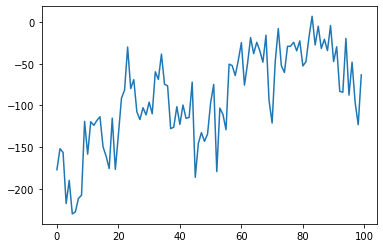

In [12]:
plt.plot(range(len(mean_total_rewards)), mean_total_rewards)
plt.show()

In [35]:
tjs = get_trajectory(env, agent, trajectory_len, visualize=True)
print(tjs['total_reward'])

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/gym/core.py:50: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  "You are calling render method, "


-356.68513848830753


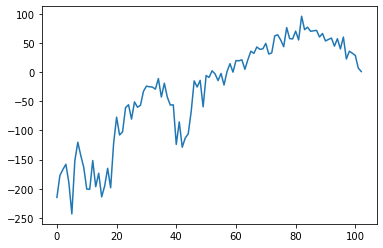

In [18]:
plt.plot(range(len(mean_total_rewards)), mean_total_rewards)
plt.show()

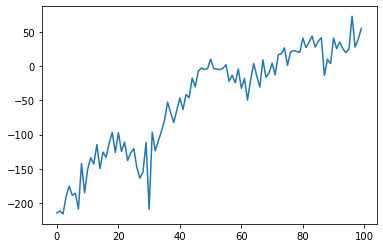

In [9]:
plt.plot(range(len(mean_total_rewards)), mean_total_rewards)
plt.show()

In [14]:
TASKS_DIR = './tasks/'
EXP_DIR = './experiments/'
for d in [TASKS_DIR, EXP_DIR]:
    os.makedirs(d, exist_ok=True)

In [9]:
def nest_permutate(seq, vals, opts):
    
    for i in opts[0]:
        if len(opts)==1:
            seq.append(vals+[i])
        else:
            nest_permutate(seq, vals+[i], opts[1:])

In [152]:
# проверяем влияние кол-ва нейронов
layers_n = [[10], [30], [65], [100], [200], [400]]
episodes_n = [400]
trajectories_n = [50, 200, 400]
trajectories_len = [500]
q_params = [0.5]
versions=['2']

In [169]:
layers_n = [[10,10], [30], [65], [100], [150], [200]]
episodes_n = [200]
trajectories_n = [10, 50, 150, 300]
trajectories_len = [500, 1000]
q_params = [0.5, 0.7, 0.8, 0.9]
versions=['1']

In [170]:
tasks = []
combins = [layers_n, versions, episodes_n,trajectories_n, trajectories_len, q_params]
nest_permutate(tasks, [], combins)
len(tasks)

192

In [171]:
tasks

[[[10, 10], '1', 200, 10, 500, 0.5],
 [[10, 10], '1', 200, 10, 500, 0.7],
 [[10, 10], '1', 200, 10, 500, 0.8],
 [[10, 10], '1', 200, 10, 500, 0.9],
 [[10, 10], '1', 200, 10, 1000, 0.5],
 [[10, 10], '1', 200, 10, 1000, 0.7],
 [[10, 10], '1', 200, 10, 1000, 0.8],
 [[10, 10], '1', 200, 10, 1000, 0.9],
 [[10, 10], '1', 200, 50, 500, 0.5],
 [[10, 10], '1', 200, 50, 500, 0.7],
 [[10, 10], '1', 200, 50, 500, 0.8],
 [[10, 10], '1', 200, 50, 500, 0.9],
 [[10, 10], '1', 200, 50, 1000, 0.5],
 [[10, 10], '1', 200, 50, 1000, 0.7],
 [[10, 10], '1', 200, 50, 1000, 0.8],
 [[10, 10], '1', 200, 50, 1000, 0.9],
 [[10, 10], '1', 200, 150, 500, 0.5],
 [[10, 10], '1', 200, 150, 500, 0.7],
 [[10, 10], '1', 200, 150, 500, 0.8],
 [[10, 10], '1', 200, 150, 500, 0.9],
 [[10, 10], '1', 200, 150, 1000, 0.5],
 [[10, 10], '1', 200, 150, 1000, 0.7],
 [[10, 10], '1', 200, 150, 1000, 0.8],
 [[10, 10], '1', 200, 150, 1000, 0.9],
 [[10, 10], '1', 200, 300, 500, 0.5],
 [[10, 10], '1', 200, 300, 500, 0.7],
 [[10, 10], '1',

In [190]:
def generate_tasks(layers_n, version, episode_n, trajectory_n, trajectory_len, q_param):
    os.makedirs(TASKS_DIR, exist_ok=True)
    files = list(glob.glob(os.path.join(TASKS_DIR, '*.json')))
    
    exp_set = set()
    for file in files:
        ed = json.load(open(file, 'r'))
        exp_id = '_'.join([str(ed['version']), str(ed['layers_n']),str( ed['episode_n']), str(ed['trajectory_len']), str(ed['trajectory_n']), str(ed['q_param'])])
        exp_set.add(exp_id)
    
#     print(exp_set)
    exp_id = '_'.join(         [version,      str(layers_n), str(episode_n), str(trajectory_len), str(trajectory_n), str(q_param)])
    if exp_id in exp_set: 
        print('Allready created', exp_id)
        return 0
    exp = {
            'id': str(time.process_time_ns()),
            'version':version,
            'layers_n': layers_n,
            'episode_n':episode_n,
            'trajectory_len':trajectory_len,
            'trajectory_n':trajectory_n,
            'q_param':q_param
    }
    f = open(os.path.join(TASKS_DIR,f'{exp["id"]}.json'), 'w')
    json.dump(exp, f)
    return 1

In [192]:
# изучаем работу слоев
# v3
# 1 ДОбавить 1 промежуточный слой
# 1-1 придумать разные конфигурации слоев


# проверяем влияние кол-ва нейронов
layer_n1 = [10, 30, 65, 100, 200, 400]
layer_n2 = [10, 30, 65, 100, 200, 400]
layers =[]
combins = [layer_n1, layer_n2]
nest_permutate(layers, [], combins)

episodes_n = [400]
trajectories_n = [100]
trajectories_len = [500]
q_params = [0.5]
tasks = []
versions=['3']
combins = [layers, versions, episodes_n,trajectories_n, trajectories_len, q_params]
nest_permutate(tasks, [], combins)
for task in tasks:
    generate_tasks(*task)


Allready created 3_[10, 10]_400_500_100_0.5
Allready created 3_[10, 30]_400_500_100_0.5
Allready created 3_[10, 65]_400_500_100_0.5
Allready created 3_[10, 100]_400_500_100_0.5
Allready created 3_[10, 200]_400_500_100_0.5
Allready created 3_[10, 400]_400_500_100_0.5
Allready created 3_[30, 10]_400_500_100_0.5
Allready created 3_[30, 30]_400_500_100_0.5
Allready created 3_[30, 65]_400_500_100_0.5
Allready created 3_[30, 100]_400_500_100_0.5
Allready created 3_[30, 200]_400_500_100_0.5
Allready created 3_[30, 400]_400_500_100_0.5
Allready created 3_[65, 10]_400_500_100_0.5
Allready created 3_[65, 30]_400_500_100_0.5
Allready created 3_[65, 65]_400_500_100_0.5
Allready created 3_[65, 100]_400_500_100_0.5
Allready created 3_[65, 200]_400_500_100_0.5
Allready created 3_[65, 400]_400_500_100_0.5
Allready created 3_[100, 10]_400_500_100_0.5
Allready created 3_[100, 30]_400_500_100_0.5
Allready created 3_[100, 65]_400_500_100_0.5
Allready created 3_[100, 100]_400_500_100_0.5
Allready created 3

In [195]:
# v4
# 2 ДОбавить 2 промежуточный слой
# 2-1 придумать разные конфигурации слоев

layer_n1 = [10, 30, 65, 100, 200, 400]
layer_n2 = [10, 30, 65, 100, 200, 400]
layer_n3 = [10, 30, 65, 100, 200, 400]
layers =[]
combins = [layer_n1, layer_n2, layer_n3]
nest_permutate(layers, [], combins)

episodes_n = [400]
trajectories_n = [100]
trajectories_len = [500]
q_params = [0.5]
tasks = []
versions=['4']
combins = [layers, versions, episodes_n,trajectories_n, trajectories_len, q_params]
nest_permutate(tasks, [], combins)
for task in tasks:
    generate_tasks(*task)

In [194]:
tasks

[[[10, 10, 10], '4', 400, 100, 500, 0.5],
 [[10, 10, 30], '4', 400, 100, 500, 0.5],
 [[10, 10, 65], '4', 400, 100, 500, 0.5],
 [[10, 10, 100], '4', 400, 100, 500, 0.5],
 [[10, 10, 200], '4', 400, 100, 500, 0.5],
 [[10, 10, 400], '4', 400, 100, 500, 0.5],
 [[10, 30, 10], '4', 400, 100, 500, 0.5],
 [[10, 30, 30], '4', 400, 100, 500, 0.5],
 [[10, 30, 65], '4', 400, 100, 500, 0.5],
 [[10, 30, 100], '4', 400, 100, 500, 0.5],
 [[10, 30, 200], '4', 400, 100, 500, 0.5],
 [[10, 30, 400], '4', 400, 100, 500, 0.5],
 [[10, 65, 10], '4', 400, 100, 500, 0.5],
 [[10, 65, 30], '4', 400, 100, 500, 0.5],
 [[10, 65, 65], '4', 400, 100, 500, 0.5],
 [[10, 65, 100], '4', 400, 100, 500, 0.5],
 [[10, 65, 200], '4', 400, 100, 500, 0.5],
 [[10, 65, 400], '4', 400, 100, 500, 0.5],
 [[10, 100, 10], '4', 400, 100, 500, 0.5],
 [[10, 100, 30], '4', 400, 100, 500, 0.5],
 [[10, 100, 65], '4', 400, 100, 500, 0.5],
 [[10, 100, 100], '4', 400, 100, 500, 0.5],
 [[10, 100, 200], '4', 400, 100, 500, 0.5],
 [[10, 100, 400], 

In [66]:
import datetime

In [69]:
start = datetime.datetime.now()

In [70]:
end = datetime.datetime.now()

In [72]:
(end - start).total_seconds()

24.043762

In [63]:
def run_experiment(eid, versions, layers_n, episode_n, trajectory_len, trajectory_n, q_param):
    state_dim = 8
    action_n = 4

    agent = CrossEntropyMethod(eid, state_dim, action_n, layer_n1)

    exp = {
        'id': eid,
        'version':versions,
        'layers_n': layers_n,
        'episode_n':episode_n,
        'trajectory_len':trajectory_len,
        'trajectory_n':trajectory_n,
        'q_param':q_param,
        'finished':false,
        'total_elapsed':0,
        'episode_data':[]
    }
    started =  datetime.datetime.now()
    episode_data_path = os.path.join(EXP_DIR, f'{eid}.json')
    mean_total_rewards = []
    episode_data = []
    json.dump(exp, open(episode_data_path,'w'))

    # env = gym.make('CartPole-v1')
    env = gym.make('LunarLander-v2')
    for _ in tqdm.tqdm_notebook(range(episode_n)):
        trajectories = [get_trajectory(env, agent, trajectory_len) for _ in range(trajectory_n)]

        mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
        mean_total_rewards.append(mean_total_reward)
        
        elite_trajectories = get_elite_trajectories(trajectories, q_param)
        episode_data.append((mean_total_reward, len(elite_trajectories)))

        if len(elite_trajectories)>0:
            agent.update_policy(elite_trajectories)
        exp['episode_data'] = episode_data
        exp['total_elapsed'] = (end - start).total_seconds()
        json.dump(exp, open(episode_data_path,'w'))
    exp['episode_data'] = episode_data
    exp['finished'] = true
    exp['total_elapsed'] = (end - start).total_seconds()
    json.dump(exp, open(episode_data_path,'w'))

In [64]:
def executor(tasks_dir, experiments_dir):
    tasks = list(glob.glob(os.path.join(tasks_dir, '*.json')))
    for task in tasks:
        task = json.load(open(task, 'r'))
        eid = task['id']
        try:
            f = open(os.path.join(experiments_dir, eid+'.json'),'x')
            f.close()
            versions = task['version']
            layers_n = task['layers_n']
            episode_n = task['episode_n']
            trajectory_len = task['trajectory_len']
            trajectory_n = task['trajectory_n']
            q_param = task['q_param']
            
            run_experiment(eid, versions, layer_n1, episode_n, trajectory_len, trajectory_n, q_param)

        except FileExistsError as err:
            pass

In [ ]:
executor(TASKS_DIR, EXP_DIR)

In [ ]:
tjs = get_trajectory(env, agent, trajectory_len, visualize=True)
print(tjs['total_reward'])

In [36]:
tjs = []
while True:
    t = get_trajectory(env, agent, trajectory_len, visualize=True)
    tjs.append(t['total_reward'])

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

In [61]:
tjs = get_trajectory(env, agent, trajectory_len, visualize=True)
print(tjs['total_reward'])

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


265.0038634828537


In [51]:
tjs = []
for _ in range(100):
    t = get_trajectory(env, agent, trajectory_len, visualize=False)
    tjs.append(t['total_reward'])

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
